# Building Ride Share Predictions

<p>This notebook provides the steps our team took to determine if it is ipossible to predict with a certain accuracy the destination of a ride share rental.</p>
<p>To start using Sagemaker go here: <a href="https://aws.amazon.com/sagemaker/">Sagemaker</a></p>
<p>The data we used we obtained from here: https://console.cloud.google.com/marketplace/details/city-of-new-york/nyc-citi-bike <p> 

## Read the whole data from S3

In [5]:
import pandas as pd
import os

In [56]:
bucket = 'data-ml-training'
path = 'data/train/'
#training_filename= 'Training_data_cleaned_only_numeric.csv'
training_filename_no_headers = 'Training_data_cleaned_only_numeric_no_headers.csv'
validation_filename = 'validation_data_cleaned_only_numeric_no_headers.csv'
testing_filename = 'test_data_set_with_stop_First.csv'
s3_test_file_path = os.path.join('s3://', bucket, path, testing_filename)
s3_path = os.path.join('s3://', bucket, path, training_filename_no_headers)

df_all = pd.read_csv(s3_path)
print(df_all)

         355   449   146  40.71625008  -74.0091059  25199  0    1988  1
0        195   468   146    40.716250   -74.009106  25805  0  1962.0  0
1        537   992   146    40.716250   -74.009106  31962  0  1961.0  0
2        386   228   146    40.716250   -74.009106  17871  0  1971.0  1
3        249    69   146    40.716250   -74.009106  26002  0  1981.0  1
4        327   304   146    40.716250   -74.009106  18060  0  1960.0  1
5        315  1086   146    40.716250   -74.009106  31346  0  1957.0  1
6       3659   995   146    40.716250   -74.009106  25243  0  1965.0  1
7        363   532   146    40.716250   -74.009106  25654  0  1977.0  0
8        327   318   146    40.716250   -74.009106  30892  0  1987.0  1
9       3002   309   146    40.716250   -74.009106  29195  0  1956.0  0
10       330   151   146    40.716250   -74.009106  20660  0  1985.0  0
11       195   282   146    40.716250   -74.009106  17426  0  1975.0  1
12       327   235   146    40.716250   -74.009106  16614  0  19

## Start Exploring the data 

In [45]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-whitegrid')
%matplotlib inline

<p>We found data on both the citi bike stations and rides from the stations. 
We removed the columns that we didn't think were relevant to our problem (like latitude/longitude of the station location, and whether or not the customer had a subscription or was a subscriber to the system.) 
 We selected the top 10 stations that had the most number of rides. For each of those stations, we exported the top 16,000 rows (sorted by date desc) (16,000 was the limit for exporting).  We kept the most recent 2,000 rides from each station to use as the testing set, and the remaining 14,000 for each as the training set. </p>

In [144]:
df_all.describe()

,end_station_id,tripduration,start_station_id,start_station_latitude,start_station_longitude,bikeid,usertype,birth_year,gender
count,140000.000000,1.400000e+05,140000.000000,140000.000000,140000.000000,140000.000000,140000.000000,137940.000000,140000.000000
mean,994.320443,7.753823e+02,672.400000,40.739491,-73.991215,26056.889229,0.053486,1977.561657,0.840979
std,1178.275217,1.383369e+04,837.542268,0.017287,0.010361,5990.204541,0.225001,12.741348,0.486085
min,72.000000,6.100000e+01,146.000000,40.713126,-74.009106,14529.000000,0.000000,1895.000000,0.000000
25%,335.000000,3.180000e+02,291.000000,40.729039,-74.000040,19999.000000,0.000000,1968.000000,1.000000
50%,458.000000,5.320000e+02,478.500000,40.738387,-73.992516,27875.000000,0.000000,1979.000000,1.000000
75%,529.000000,8.692500e+02,519.000000,40.751873,-73.982614,31205.000000,0.000000,1988.000000,1.000000
max,3686.000000,4.845321e+06,3158.000000,40.771639,-73.975739,33689.000000,1.000000,2002.000000,2.000000


### Date-Time Features 

In [89]:
df_all['ts'] = df_all['starttime'].apply(pd.Timestamp)

In [90]:
df_all['weekday'] = df_all['ts'].dt.weekday
df_all['day'] = df_all['ts'].dt.day
df_all['month'] = df_all['ts'].dt.month
df_all['year'] = df_all['ts'].dt.year
df_all['hour'] = df_all['ts'].dt.hour
print(df_all)

        tripduration                   starttime                    stoptime  \
0                449  2018-05-11T08:54:13.812000  2018-05-11T09:01:42.990000   
1                468  2018-05-11T08:49:14.338000  2018-05-11T08:57:02.823000   
2                992  2018-05-11T08:46:32.322000  2018-05-11T09:03:04.410000   
3                228  2018-05-11T08:44:36.301000  2018-05-11T08:48:24.306000   
4                 69  2018-05-11T08:25:49.964000  2018-05-11T08:26:59.784000   
5                304  2018-05-11T08:21:02.372000  2018-05-11T08:26:06.651000   
6               1086  2018-05-11T08:07:54.407000  2018-05-11T08:26:01.379000   
7                995  2018-05-11T07:59:41.058000  2018-05-11T08:16:16.342000   
8                532  2018-05-11T07:53:30.966000  2018-05-11T08:02:23.145000   
9                318  2018-05-11T07:48:11.026000  2018-05-11T07:53:29.403000   
10               309  2018-05-11T07:36:39.253000  2018-05-11T07:41:48.803000   
11               151  2018-05-11T07:32:4

In [91]:
#TODO: we can create some charts to show something? 
#time_features = ['day', 'month', 'weekday', 'year', 'hour']

#fig = plt.figure(figsize=(20,12))
#fig.subplots_adjust(hspace=0.4, wspace=0.4)

#for i in range(len(time_features)):
#    ax = fig.add_subplot(2, 3, i+1)
#    sns.boxplot(x=time_features[i], y="fare_amount", data=df_all[df_all['year'] >= 2013], showfliers=False)

#plt.show()

### Geographic 

https://www.kaggle.com/breemen/nyc-taxi-fare-data-exploration

In [92]:
nyc_box = (-74.1, -73.7, 40.6, 40.9)

In [93]:
def filter_coordinates(df, box):
    return (df.start_station_longitude >= box[0]) & (df.start_station_longitude <= box[1]) & \
           (df.start_station_latitude >= box[2]) & (df.start_station_latitude <=box[3]) & \
           (df.end_station_longitude >= box[0]) & (df.end_station_longitude <= box[1]) & \
           (df.end_station_latitude >= box[2]) & (df.end_station_latitude <= box[3])

In [94]:
def plot_hires(df, box, figsize=(12, 12), ax=None, c=sns.color_palette("husl", 2)):
    if ax == None:
        fig, ax = plt.subplots(1, 1, figsize=figsize)

    idx = filter_coordinates(df, box)
    ax.scatter(df[idx].start_station_longitude, df[idx].start_station_latitude, c=c[0], s=0.1, lw=0.1, alpha=0.5)
    ax.scatter(df[idx].end_station_longitude, df[idx].end_station_latitude, c=c[1], s=0.1, lw=0.1, alpha=0.5)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


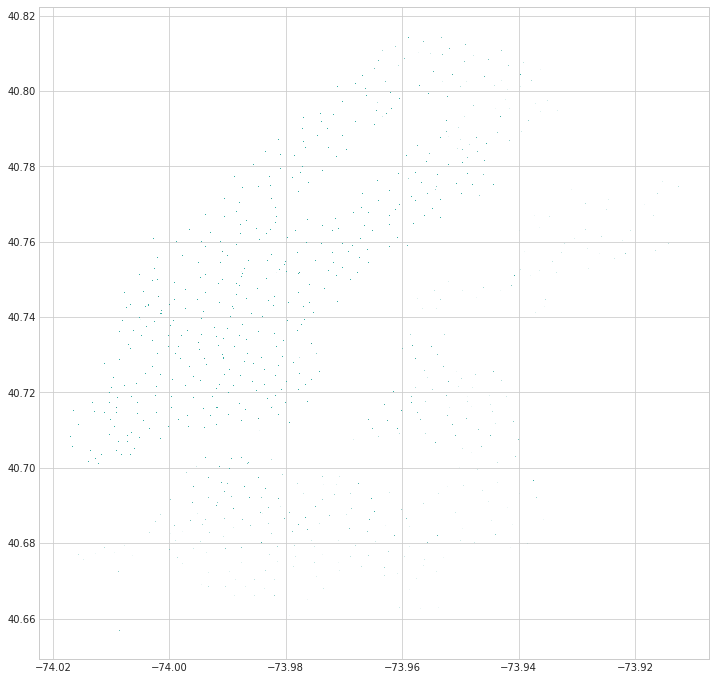

In [95]:
plot_hires(df_all, nyc_box)

<p>In the scatter plot above, it seems that there is a lot of variation in the destinations of the 10 stations that are are looking at.</p>

## Train model 

In [36]:
from sagemaker.amazon.amazon_estimator import get_image_uri
import sagemaker
from sagemaker import get_execution_role
import boto3
from datetime import datetime

In [37]:
path_train = os.path.join(path, training_filename_no_headers)
print(path_train)
path_validation = os.path.join(path, validation_filename)
print(path_test)

data/train/Training_data_cleaned_only_numeric_no_headers.csv
data/train/testing_data_cleaned_only_numeric_no_headers.csv


In [38]:
container = get_image_uri(boto3.Session().region_name, 'xgboost')

In [39]:
#s3_input_trains3_inpu  = sagemaker.s3_input(s3_data='s3://{}/{}'.format(bucket, path_train),
#                                            content_type='csv',
#                                            distribution='ShardedByS3Key')
#print(s3_input_trains3_inpu)
#s3_input_test = sagemaker.s3_input(s3_data='s3://{}/{}'.format(bucket, path_test),
#                                         content_type='csv', 
#                                         distribution='ShardedByS3Key')
train_channel = sagemaker.session.s3_input('s3://{}/{}'.format(bucket, path_train), content_type='text/csv')
print(train_channel)
validation_channel = sagemaker.session.s3_input(s3_data='s3://{}/{}'.format(bucket, path_test), content_type='text/csv')
print(validation_channel)
data_channels = {'train': train_channel, 'validation': validation_channel}


In [40]:
sess = sagemaker.Session()
print(sess)
role = get_execution_role()
print(role)

arn:aws:iam::023375022819:role/service-role/AmazonSageMaker-ExecutionRole-20190520T113312


In [26]:
training_job_path = os.path.join('training_jobs', datetime.now().strftime('%Y-%m-%d-%H-%M-%S'))
print(training_job_path)

training_jobs/2019-06-20-13-48-05


In [27]:
xgb = sagemaker.estimator.Estimator(container,
                                    role, 
                                    train_instance_count=4, 
                                    train_instance_type='ml.m4.xlarge',
                                    output_path='s3://{}/{}/output'.format(bucket,training_job_path),
                                    sagemaker_session=sess)

In [28]:
's3://{}/{}/output'.format(bucket,training_job_path)
print('s3://{}/{}/output'.format(bucket,training_job_path))

s3://data-ml-training/training_jobs/2019-06-20-13-48-05/output


In [29]:
xgb.set_hyperparameters(max_depth=9,
                        eta=0.2,
                        gamma=4,
                        min_child_weight=300,
                        subsample=0.8,
                        silent=0,
                        objective='reg:linear',
                        early_stopping_rounds=10,
                        num_round=10000)


In [30]:
xgb.fit(inputs=data_channels,logs=True)

2019-06-20 13:48:17 Starting - Starting the training job...
2019-06-20 13:48:18 Starting - Launching requested ML instances......
2019-06-20 13:49:22 Starting - Preparing the instances for training......
2019-06-20 13:50:30 Downloading - Downloading input data...
2019-06-20 13:51:04 Training - Training image download completed. Training in progress.
Arguments: train
[2019-06-20:13:51:04:INFO] Running distributed xgboost training.
Arguments: train
[2019-06-20:13:51:04:INFO] Running distributed xgboost training.
[2019-06-20:13:51:05:INFO] Number of hosts: 4, master IP address: 10.44.0.3, host IP address: 10.40.0.3.
[2019-06-20:13:51:05:INFO] Finished Yarn configuration files setup.

starting datanode, logging to /opt/amazon/hadoop/logs/hadoop--datanode-aws.out
Arguments: train
[2019-06-20:13:51:05:INFO] Running distributed xgboost training.
[2019-06-20:13:51:06:INFO] Number of hosts: 4, master IP address: 10.44.0.3, host IP address: 10.44.0.3.
[2019-06-20:13:51:06:INFO] Finished Yarn con


2019-06-20 13:52:50 Uploading - Uploading generated training model[2019-06-20:13:52:41:INFO] Master host is not alive. Training might have finished. Shutting down.... Check the logs for algo-1 machine.
[2019-06-20:13:52:44:INFO] Master host is not alive. Training might have finished. Shutting down.... Check the logs for algo-1 machine.
[2019-06-20:13:52:46:INFO] Master host is not alive. Training might have finished. Shutting down.... Check the logs for algo-1 machine.

2019-06-20 13:52:53 Completed - Training job completed
Billable seconds: 571


## Deploy the model 

To deploy the model we move to the Amazon Sagemaker console and perform the following steps: <br>
1) Create model <br>
2) Create an endpoint configuration <br>
3) create and endpoint <br>

In [62]:
training_job_name='stop-estimator'
xgb_predictor = xgb.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge', endpoint_name='stop-estimator')
print(xgb_predictor)

---------------------------------------------------------------------------------------!<sagemaker.predictor.RealTimePredictor object at 0x7f0035d8a828>


## Evaluate results 

Parts taken from here:<br>
https://aws.amazon.com/blogs/machine-learning/simplify-machine-learning-with-xgboost-and-amazon-sagemaker/

In [50]:
from sagemaker.predictor import csv_serializer

In [58]:
s3_validation_file_path = os.path.join('s3://', bucket, path, validation_filename)
df_valid = pd.read_csv(s3_validation_file_path , header=None)
df_test = pd.read_csv(s3_test_file_path, header=None)
#print(df_test)

In [69]:
import ast
endpoint_name = 'stop-estimator'
content_type = 'text/csv'
data = '867,146,40.71625008,-74.0091059,20224,0,196,1' 
runtime = boto3.Session().client('sagemaker-runtime')
response = runtime.invoke_endpoint(EndpointName=endpoint_name,\
                                    ContentType='text/csv',\
                                    Body=data)
results = response['Body'].read().decode()
print(results)

989.685913086


In [70]:
df_val = pd.DataFrame()
df_val['prediction'] = predictions
df_val['target'] = df_test[0]

NameError: name 'predictions' is not defined

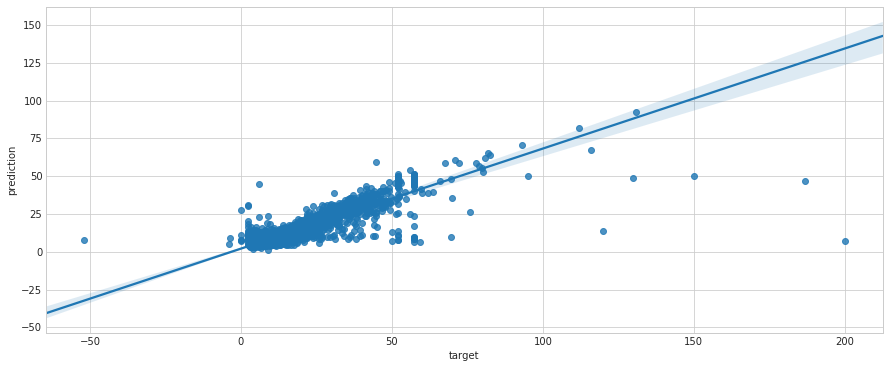

In [72]:
plt.figure(figsize=(15,6))
sns.regplot(x=df_val["target"], y=df_val["prediction"])
plt.show()

In [60]:
df_val['err'] = (df_val["target"] - df_val["prediction"])

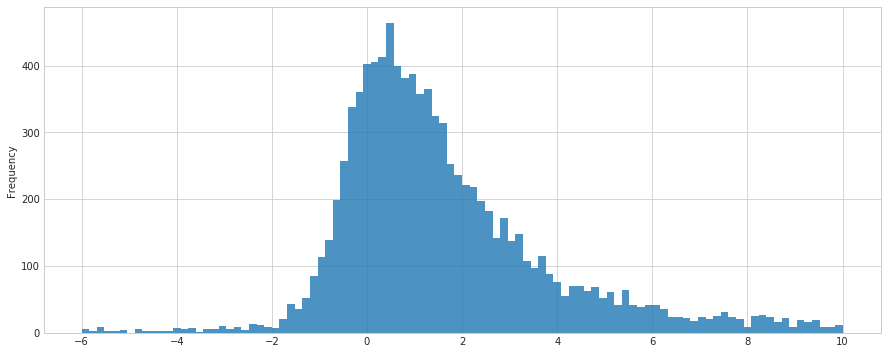

In [68]:
df_val['err'].plot(kind='hist', bins=100, range=(-6,10), alpha=0.8, figsize=(15,6))
plt.show()

In [133]:
df_val.describe()

,prediction,target,err
count,10000.000000,10000.000000,10000.000000
mean,10.136426,12.146189,2.009763
std,7.866508,10.783085,4.924559
min,1.217842,-52.000000,-60.065754
25%,5.855069,6.500000,0.157199
50%,7.719818,9.000000,1.156649
75%,10.799477,13.500000,2.742055
max,92.332817,200.000000,192.756607


## Make online predictions

In [129]:
import ast

In [130]:
csv_path = os.path.join('s3://', bucket, path_val, 'year=2015', 'month=4','run-1534713776930-part-r-00000')
df = pd.read_csv(csv_path, header=None)

n = 20
features = df.iloc[0:n,1:].values
values  = df.iloc[0:n,0].values

In [131]:
endpoint_name = 'xgboost-2018-08-20-19-04-07-244'
content_type = 'text/csv'
data = "\n".join(["\n".join([",".join(str(x) for x in sample)]) for sample in features])

runtime = boto3.Session().client('sagemaker-runtime')
response = runtime.invoke_endpoint(EndpointName=endpoint_name,\
                                   ContentType='text/csv',\
                                   Body=data) 

In [132]:
result = list(ast.literal_eval(response['Body'].read().decode()))
print(result)

[42.3999252319, 6.63605451584, 8.07524490356, 7.78959321976, 5.41954421997, 15.7531328201, 6.93523740768, 8.32779502869, 17.6728153229, 8.15808486938, 8.18750667572, 5.9746928215, 20.5012798309, 6.00341939926, 6.62830781937, 6.69897270203, 6.00716352463, 6.65784788132, 7.12238788605, 11.7225542068]
